# Segmentation of cell images
## Project 9

In [1]:
import numpy as np
import os
import torch
import time
import matplotlib.pyplot as plt
from skimage import io, transform
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from os import listdir
from os.path import splitext
from glob import glob
from natsort import natsorted
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise, Rotate)
from albumentations.pytorch import ToTensor
import shutil
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)




cuda:0


In [2]:
## Hyper parameters
slowPC = False
val_percent=0.1
batch_size=1
epochs=100
learning_rate=0.001

test_a_dir_img = 'data/testA/img/'
test_a_dir_mask = 'data/testA/mask/'

test_b_dir_img = 'data/testB/img/'
test_b_dir_mask = 'data/testB/mask/'


## 1. Loading and normalizing the Gland dataset

Load the data using a custom dataloader from pytorch, and do some preprocessing.

In [3]:
def get_transforms():
            list_transforms = []
            
            list_transforms.extend(
                    [
            ToTensor(),
                    ])
            list_trfms = Compose(list_transforms)
            return list_trfms

def standardize(img, mean, std):
        img = (img - mean) / std
        return img


class cellData(Dataset):
    """Gland dataset."""
    def __init__(self, imgs_dir, masks_dir):
        
        img_name_list = [splitext(file)[0] for file in listdir(imgs_dir) if not file.startswith('.')]

        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.ids = natsorted(img_name_list)
        red = []
        redSD = []
        blue= []
        blueSD = []
        green = []
        greenSD = []

        for idx in self.ids:
            img_file = glob(self.imgs_dir + idx + '.*')
            img = io.imread(img_file[0])[:,:,:].astype('float32')
            red.append(np.mean(img[:,:,0]))
            redSD.append(np.std(img[:,:,0]))
            green.append(np.mean(img[:,:,1]))
            greenSD.append(np.std(img[:,:,1]))
            blue.append(np.mean(img[:,:,2]))
            blueSD.append(np.std(img[:,:,2]))
    
        self.red_mean = np.mean(red)
        self.red_sd = np.mean(redSD)
        
        self.blue_mean = np.mean(blue)
        self.blue_sd = np.mean(blueSD)
        
        self.green_mean = np.mean(green)
        self.green_sd = np.mean(greenSD)
        
        self.transform = get_transforms()
            

    def __len__(self):
        return len(self.ids)
            

    def __getitem__(self,i):
        idx = self.ids[i]

        found_img_files = glob(self.imgs_dir + idx + '.*')
        img_name = found_img_files[0]
        img = io.imread(img_name).astype('float32')
        img = transform.resize(img,(512,512))
        r_channel = standardize(img[:,:,0], self.red_mean, self.red_sd)
        g_channel = standardize(img[:,:,1], self.green_mean, self.green_sd)
        b_channel = standardize(img[:,:,2], self.blue_mean, self.blue_sd)
        img = np.stack([r_channel, g_channel, b_channel], axis=-1)

        found_mask_files = glob(self.masks_dir + idx + '_anno.*')
        mask_name = found_mask_files[0]
        mask = self.get_mask(mask_name, 512, 512).astype('float32')


        ## Do tranformations.         
        augmented = self.transform(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        mask = mask[0].permute(2, 0, 1)
        
        return (img, torch.round(mask))


    def get_mask(self,mask_file,IMG_HEIGHT, IMG_WIDTH):
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        mask_ = io.imread(mask_file)
        mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
        mask_ = np.expand_dims(mask_,axis=-1)
        mask = np.maximum(mask, mask_)
        
        return mask
            

In [4]:
# Loading the data
test_a_data = cellData(imgs_dir=test_a_dir_img, masks_dir=test_a_dir_mask)
test_b_data = cellData(imgs_dir=test_b_dir_img, masks_dir=test_b_dir_mask)

# Checking the shape of the images and masks 
print("Number of images in test A: " + str(len(test_a_data)))
print("Number of images in test B: " + str(len(test_b_data)))

for img,msk in test_a_data:
    print("Image shape: " + str(img.shape))
    print("Mask shape: " + str(msk.shape))
    break


Number of images in test A: 60
Number of images in test B: 20
Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([1, 512, 512])


In [5]:
test_a_loader = torch.utils.data.DataLoader(test_a_data, batch_size=batch_size, shuffle=False)
test_b_loader = torch.utils.data.DataLoader(test_b_data, batch_size=batch_size, shuffle=False)

test_a_data_iter = iter(test_a_loader)
test_b_data_iter = iter(test_b_loader)


In [6]:

# converting image tensor to numpy array
def image_convert(image, data):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0)) 
    std = np.array((data.red_sd, data.green_sd, data.blue_sd))
    mean = np.array((data.red_mean, data.green_mean, data.blue_mean))
    image  = (std * image + mean)
    image = (image).astype(np.uint8)
    return image

# converting mask tensor to numpy array
def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

In [7]:
## Visualisation of original images and actual masks
def plot_img(no):
    if no > len(images):
        print("The batch does only contain {} images.".format(len(images)))
        no = len(images)
    
    plt.figure(figsize=(15,15))
    
    for idx in range(0,no):
          image = image_convert(images[idx], test_a_data)
          plt.subplot(2,no,idx+1)
          plt.title('image')
          plt.imshow(image)
    for idx in range(0,no):
          mask = mask_convert(masks[idx])
          plt.subplot(2,no,idx+no+1)
          plt.title('mask')
          plt.imshow(mask,cmap='gray')
    plt.show()


The batch does only contain 1 images.


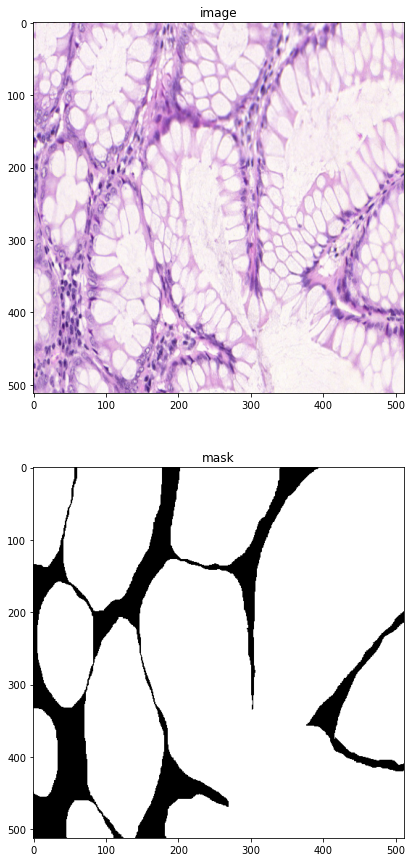

In [8]:
# get the images and mask in the first batch of test a. 
images, masks = next(test_a_data_iter)

# Show images and masks
plot_img(2)

## 2. Deffining the Unet structure

In [9]:
# Unet using 'ConvTranspose2d' but only 4 down and 3 up. 

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.25),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.25)
    )

class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dblock1 = double_conv(3, 64)
        self.dblock2 = double_conv(64, 128)
        self.dblock3 = double_conv(128,256)
        self.dblock4 = double_conv(256,512)

        self.up1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.ublock1 = double_conv(512,256)

        self.up2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.ublock2 = double_conv(256,128)

        self.up3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.ublock3 = double_conv(128,64)

        self.last_layer = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()

    def forward(self,image):
        # Encoder
        x1 = self.dblock1(image)
        x2 = self.max_pool(x1)

        x3 = self.dblock2(x2)
        x4 = self.max_pool(x3)

        x5 = self.dblock3(x4)
        x6 = self.max_pool(x5)

        x7 = self.dblock4(x6)
        

        # Decoder
        x = self.up1(x7)
        x = self.ublock1(torch.cat([x, x5], dim=1))

        x = self.up2(x)
        x = self.ublock2(torch.cat([x, x3], dim=1))

        x = self.up3(x)
        x = self.ublock3(torch.cat([x, x1], dim=1))


        out = self.last_layer(x)
        return out

## 3. Metrices

In [10]:
import numpy as np
from scipy.spatial import cKDTree

def hausdorff_distance(image0, image1):
    """Calculate the Hausdorff distance between nonzero elements of given images.
    The Hausdorff distance [1]_ is the maximum distance between any point on
    ``image0`` and its nearest point on ``image1``, and vice-versa.
    Parameters
    ----------
    image0, image1 : ndarray
        Arrays where ``True`` represents a point that is included in a
        set of points. Both arrays must have the same shape.
    Returns
    -------
    distance : float
        The Hausdorff distance between coordinates of nonzero pixels in
        ``image0`` and ``image1``, using the Euclidian distance.
    References
    ----------
    .. [1] http://en.wikipedia.org/wiki/Hausdorff_distance
    Examples
    --------
    >>> points_a = (3, 0)
    >>> points_b = (6, 0)
    >>> shape = (7, 1)
    >>> image_a = np.zeros(shape, dtype=np.bool)
    >>> image_b = np.zeros(shape, dtype=np.bool)
    >>> image_a[points_a] = True
    >>> image_b[points_b] = True
    >>> hausdorff_distance(image_a, image_b)
    3.0
    """
    a_points = np.transpose(np.nonzero(image0))
    b_points = np.transpose(np.nonzero(image1))

    # Handle empty sets properly:
    # - if both sets are empty, return zero
    # - if only one set is empty, return infinity
    if len(a_points) == 0:
        return 0 if len(b_points) == 0 else np.inf
    elif len(b_points) == 0:
        return np.inf

    return max(max(cKDTree(a_points).query(b_points, k=1)[0]),
               max(cKDTree(b_points).query(a_points, k=1)[0]))

In [11]:
import numpy as np
from skimage.measure import label
from sklearn.metrics import confusion_matrix
class BinaryImageMetrics():
    def __init__(self, y_true, y_pred):
        #TODO: Add README.md and documentation
        #TODO: implement Adjusted Rand Index and https://web.stanford.edu/class/cs273/scribing/2004/class8/scribe8.pdf
        
        # Numpy have the bug : ValueError: cannot set WRITEABLE flag to True of this array
        # That is why we copy the array

        # We force the predictions to be binary

        y_true = np.copy(y_true).astype("int64")
        y_pred = np.copy(y_pred).astype("int64")
        y_true[y_true>0]=1
        y_pred[y_pred>0] = 1
        self.y_true= y_true
        self.y_pred = y_pred
        self.y_true_label = label(self.y_true)
        self.y_pred_label = label(self.y_pred)

    def get_count(self):
        count_y_true = np.max(self.y_true_label)
        count_y_pred = np.max(self.y_pred_label)
        if count_y_pred == 0 or count_y_true == 0:
            return 0.0
        else:
            return min(count_y_true/count_y_pred, count_y_pred/count_y_true)

    def get_f1(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
            
        if y_true.max() == 0 and y_pred.max()==0:
            return 0.0 
            
        tp, fp, _, fn = self._confusion_matrix(y_true, y_pred)
        f1 = 2*tp / (2*tp +fp + fn)
        return f1

    def get_hausdroff_dist(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
        
        if y_true.max() == 0 or y_pred.max() == 0:
            haus_dist = np.sqrt(y_true.shape[0]*y_true.shape[1])
        else:
            haus_dist = hausdorff_distance(y_true, y_pred)
        return haus_dist

    def get_f1_obj(self):
        f1_obj = 0
        total_y_pred = max(np.bincount(self.y_pred.flatten(), minlength=2)[1],1.0)
        total_y_true = max(np.bincount(self.y_true.flatten(), minlength=2)[1],1,0)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=False)
            f1 = (np.bincount(gi.flatten(), minlength=2)[1]/total_y_true)*self.get_f1(y_true=gi, y_pred=si)
            f1_obj += f1

        for idx in range(1, self.y_pred_label.max()+1):
            si, gi = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=True)
            f1 = (np.bincount(si.flatten(), minlength=2)[1]/total_y_pred)*self.get_f1(y_true=si, y_pred=gi)
            f1_obj += f1

        f1_obj /= 2

        return f1_obj

    def get_hausdorff_obj_distance(self):
        haus_dist_obj = 0
        total_p = np.bincount(self.y_pred.flatten(), minlength=2)[1]
        total_y_true = np.bincount(self.y_true.flatten(), minlength=2)[1]
        
        if total_y_true == 0 or total_p == 0:
            # Note this conversion is different from
            # https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/evaluation/
            # But the Hausdorff distance is not defined for non-overlapping objects.
            # Note that the distance of sqrt(h^2+w^2) is an arbary choice.
            # 0.0 would skew the distance to much to the positive side, and
            # infinite is misleading. 
            # In case both objects are empty, we return the max dist of y_true
            return np.sqrt(self.y_true.shape[0]**2+self.y_true.shape[1]**2)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=True, y_true_p_switch=False)
            if gi.max() == 0 or si.max() == 0:
                haus_dist = ((gi.shape[0]*gi.shape[1])/total_y_true)*np.sqrt(gi.shape[0]**2+gi.shape[1]**2)
            else:
                haus_dist = (np.bincount(gi.flatten())[1]/total_y_true)*self.get_hausdroff_dist(y_true=gi, y_pred=si)
            haus_dist_obj += haus_dist

        for idx in range(1, self.y_pred_label.max()+1):
            si, gi = self._get_overlap(idx, return_rectangle=True, y_true_p_switch=True)
            if gi.max() == 0 or si.max() == 0:
                haus_dist = ((si.shape[0]*si.shape[1])/total_p)*np.sqrt(si.shape[0]**2+si.shape[1]**2)
            else:
                haus_dist = (np.bincount(si.flatten())[1]/total_p)*self.get_hausdroff_dist(y_true=gi, y_pred=si)
            haus_dist_obj += haus_dist

        haus_dist_obj /= 2
        return haus_dist_obj

    def _confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true.flatten(), y_pred.flatten(), labels=[0,1])
        tn, fn, tp, fp = cm[0,0], cm[1,0], cm[1,1], cm[0,1]
        return tp, fp, tn, fn
    
    def _get_overlap(self, idx, return_rectangle=False, y_true_p_switch=False):
        if y_true_p_switch:
            y_pred = self.y_true_label
            y_true = self.y_pred_label
        else:
            y_true = self.y_true_label
            y_pred = self.y_pred_label

        roi_y_true = np.argwhere(y_true == idx)
        roi_p = y_pred[roi_y_true[:,0],roi_y_true[:,1]]
        
        # Finds max overlap, excluding background
        matching_idx = np.bincount(roi_p)
        if len(matching_idx)<=1:
            matching_idx = 0
        else:
            matching_idx = matching_idx[1:].argmax()+1

        if return_rectangle:
            bbox, min_x, min_y = self._bounding_box(roi_y_true, at_origon=True)
            roi_p = np.argwhere(y_pred == matching_idx)
            roi_p[:,0] = roi_p[:,0]-min_x
            roi_p[:,1] = roi_p[:,1]-min_y
            roi_p[:,0] = np.clip(roi_p[:,0], bbox[0], bbox[2])
            roi_p[:,1] = np.clip(roi_p[:,1], bbox[1], bbox[3])

            roi_y_true[:,0] = roi_y_true[:,0]-min_x
            roi_y_true[:,1] = roi_y_true[:,1]-min_y

            roi_y_true_box = np.zeros((bbox[2]+1, bbox[3]+1), dtype=np.uint8)
            roi_p_box = np.zeros((bbox[2]+1, bbox[3]+1), dtype=np.uint8)

            roi_y_true_box[roi_y_true[:,0],roi_y_true[:,1]] = idx           
            roi_p_box[roi_p[:,0],roi_p[:,1]] = matching_idx
            roi_y_true = roi_y_true_box # Convience for return function
            roi_p = roi_p_box 

        else:
            roi_p[roi_p!=matching_idx] = 0
            roi_y_true = np.ones_like(roi_p)*idx #Faster than self.true_label[roi[:,0],roi[:,1]]

        roi_y_true[roi_y_true>0]=1
        roi_p[roi_p>0]=1
        if y_true_p_switch:
            return roi_y_true, roi_p
        else:
            return roi_p, roi_y_true

    def _bounding_box(self, points, at_origon=False):
        bbox = [min(points[:,0]), min(points[:,1]), max(points[:,0]), max(points[:,1])]
        if at_origon:
            min_x = bbox[0]
            min_y = bbox[1]
            bbox = [bbox[0] - min_x,
                    bbox[1] - min_y,
                    bbox[2] - min_x,
                    bbox[3] - min_y]
            return bbox, min_x, min_y
        else:
            return bbox


## 4. Loading a model

In [12]:
torch.cuda.empty_cache()
dir_model = 'checkpoint/best/100EpochModelConvTranspose2d_4x3.pt'
checkpoint = torch.load(dir_model)

model = Unet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
valid_loss_min = checkpoint['valid_loss_min']


In [13]:
def runMetrics(test):
        count_scores = []
        f1_scores = []
        f1_obj_scores = []
        hausdorff_obj_distance_scores = []

        counter = 0
        for image,mask in test:

                counter = counter + 1 
                print("counter: {}/{}".format(counter,len(test)))
                
                image = image.to(device,dtype=torch.float)
                mask = mask.to(device,dtype=torch.float)
                y_pred = model.forward(image)


                for i in range(batch_size):
                        
                        truth = mask_convert(mask[i])
                        predicted = mask_convert(torch.round(y_pred[i]))

                        metrics = BinaryImageMetrics(truth, predicted)
                        
                        count = metrics.get_count()
                        count_scores.append(count)
                        

                        f1 = metrics.get_f1()
                        f1_scores.append(f1)
                        

                        f1_obj = metrics.get_f1_obj()
                        f1_obj_scores.append(f1_obj)


                        hausdorff_obj_distance = metrics.get_hausdorff_obj_distance()
                        hausdorff_obj_distance_scores.append(hausdorff_obj_distance)
                        
        return count_scores, f1_scores, f1_obj_scores, hausdorff_obj_distance_scores        
        

def print_metrics(set ,count_scores, f1_scores, f1_obj_scores, hausdorff_obj_distance_scores):

        print("------------------"+ set +"---------------------")
        print("Count mean: {}".format(sum(count_scores) / len(count_scores)))
        print("F1 mean: {}".format(sum(f1_scores) / len(f1_scores)))
        print("F1 Object mean: {}".format(sum(f1_obj_scores) / len(f1_obj_scores)))
        print("Hausdorff Object distance mean: {}".format(sum(hausdorff_obj_distance_scores) / len(hausdorff_obj_distance_scores)))


In [14]:

model.eval()
print("Test A")
#count_scoresA, f1_scoresA, f1_obj_scoresA, hausdorff_obj_distance_scoresA = runMetrics(test=test_a_loader)
print("Test B")
#count_scoresB, f1_scoresB, f1_obj_scoresB, hausdorff_obj_distance_scoresB = runMetrics(test=test_b_loader)

#print_metrics("Test Set A", count_scoresA, f1_scoresA, f1_obj_scoresA, hausdorff_obj_distance_scoresA)
#print_metrics("Test Set B", count_scoresB, f1_scoresB, f1_obj_scoresB, hausdorff_obj_distance_scoresB)
          

Test A
Test B


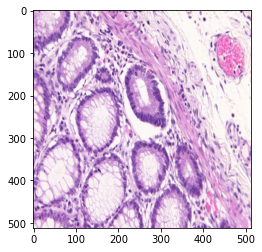

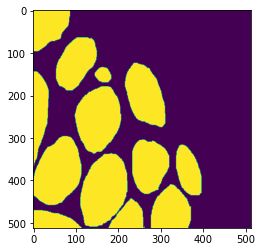

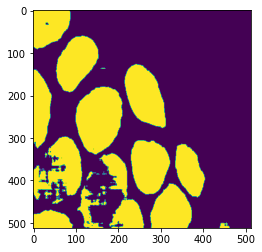

In [23]:
model.eval()



image = test_a_data[18][0]
image = image.unsqueeze(0)
mask = test_a_data[18][1]
mask = mask.unsqueeze(0)
image = image.to(device,dtype=torch.float)
mask = mask.to(device,dtype=torch.float)
y_pred = model.forward(image)

plt.imshow(image_convert(image[0], test_a_data))
plt.show()
plt.imshow(mask_convert(mask[0]))
plt.show()
plt.imshow(mask_convert(torch.round(y_pred[0])))


In [48]:
import colorsys
import random
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors
def apply_mask_white(image, mask, alpha=0.4, color=(0.1,0.2,0.2)):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask>0.5,
                                    (1 - alpha) + alpha * color[c] * 255,
                                    image[:, :, c])
    return image

In [49]:
dir_img = 'data/train/img/'
dir_mask = 'data/train/mask/'

data  = cellData(dir_img, dir_mask)

image_with_mask = image_convert(data[52][0], data)
color = random_colors(10)[0]    
image_with_mask = apply_mask_white(image_with_mask, y_pred[0].cpu())

plt.imshow(image_with_mask)

data[19][0]


tensor([[[ 0.9161,  0.8719,  0.7303,  ...,  1.2075,  1.1764,  0.9515],
         [ 0.7267,  0.5304,  0.4306,  ...,  1.2112,  1.2873,  1.1669],
         [ 0.6286,  0.3146,  0.2335,  ...,  1.3162,  1.2789,  0.9381],
         ...,
         [-0.3192, -0.4215, -0.3950,  ...,  1.2627,  1.2421,  1.1888],
         [ 0.2222,  0.0474,  0.0082,  ...,  1.2682,  1.1960,  1.0283],
         [ 0.7408,  0.6145,  0.0903,  ...,  1.2648,  1.2611,  1.2758]],

        [[ 1.5950,  1.4654,  1.2373,  ...,  2.0047,  2.0060,  1.8572],
         [ 1.3669,  1.0700,  0.8765,  ...,  2.0228,  2.0923,  1.9607],
         [ 1.2313,  0.8220,  0.6448,  ...,  2.1767,  2.1392,  1.7921],
         ...,
         [ 0.5526,  0.3630,  0.2907,  ...,  1.9748,  1.9155,  1.8769],
         [ 1.0019,  0.7046,  0.5791,  ...,  2.0140,  1.9300,  1.7664],
         [ 1.4401,  1.0907,  0.6130,  ...,  1.9006,  1.8297,  1.7850]],

        [[ 1.2362,  1.1756,  0.8901,  ...,  1.2055,  1.2044,  1.2290],
         [ 1.2777,  1.0123,  0.8319,  ...,  1

In [50]:
image_with_mask.shape

(512, 512, 3)